# CNN Autoencoder

For initial modeling, I've implemented a CNN autoencoder to learn latent features corresponding to MRI scans containing brain tumors. The model will be trained on its ability to reconstruct batches of tumor images. The loss function used is structural similarity index measure which measures the similarity between two images. I'll provide a more in depth description on the loss function in later updates. 

The model architecture uses a encoder-decoder framework where the number of channels and kernel size increase with each layer in the encoder and decreases in the same fashion for the decoder network. This performs a compression-expansion transformation of the data in order to preserve the key features of each image.

In [64]:
!pip install torchinfo
!pip install pytorch-msssim

In [298]:
import os  
import glob
import cv2
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import NMF 
from sklearn.metrics import roc_curve, auc, classification_report

import PIL 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from IPython.display import Image

# torch-based imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary 
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import pytorch_msssim

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [68]:
random_seed = 124
np.random.seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [230]:
main_path = '/content/drive/MyDrive/Academic/Spring 2022/MA 544 Linear Algebra/Anomaly-Detection-Numerical-LinAlg-for-Big-Data/MRIscans'

train_path =  main_path + '/Training/'
val_path = main_path + '/Validation/'
test_path = main_path + '/Testing/'

train_files = glob.glob(os.path.join(train_path, "no_tumor_train",'*.*'))
val_files = glob.glob(os.path.join(val_path, "no_tumor_val", "*.*"))

test_files_pos = glob.glob(os.path.join(test_path, 'extra_tumor_imgs', '*.*'))
test_files_neg = glob.glob(os.path.join(test_path, 'no_tumor', '*.*'))
test_files = test_files_pos + test_files_neg

test_labels = np.array([1]*len(test_files_pos)+[0]*len(test_files_neg))

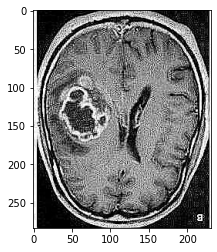

In [233]:
tumor_sample = cv2.imread(test_files_pos[i])
plt.imshow(tumor_sample)
plt.show()

i+=1

In [232]:
print(f'Number of training files: {len(train_files)}')
print(f'Number of validation files: {len(val_files)}')
print(f'Number of test files: {len(test_files)}')

print(f'\nNumber of tumor images in test set: {len(test_files_pos)}')
print(f'Number of non-tumor images in test set: {len(test_files_neg)}')

Number of training files: 1841
Number of validation files: 399
Number of test files: 946

Number of tumor images in test set: 208
Number of non-tumor images in test set: 738


## Dataset Class

In [234]:
class CT_Dataset(Dataset):
    def __init__(self, img_path, test=False, labels=None, img_transforms=None, grayscale=True):
        
        self.img_path = img_path
        self.test = test 
        self.labels = labels 

        # Default Transforms
        if img_transforms is None:
            self.transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((250, 250)),
                                                  ])
        # Custom Transforms
        else:
            self.transforms = img_transforms
    
    def __getitem__(self, index):
        # load images
        cur_path = self.img_path[index]
        cur_img = PIL.Image.open(cur_path).convert('L')
        cur_img = self.transforms(cur_img)

        if self.test:
            return cur_img, self.labels[index]

        else:
            return cur_img
    
    def __len__(self):
        return len(self.img_path)

## Preprocessing Functions

In [293]:
class randSVD_recon(object):
    
    def __call__(self, img):

        k = 35

        img_height, img_width = img.shape[1], img.shape[2]
        img = np.asarray(img).reshape(img_height, img_width)
        
        U, S, V = randomized_svd(img, n_components=k, random_state=0)
        recon = np.dot(U[:,:k], V[:k,:] * S[:k].reshape(k,1))

        recon = torch.Tensor(recon).reshape(1, img_height, img_width)

        return recon

    def __repr__(self):
        return self.__class__.__name__+'()'


class NMF_reconstruction(object):

    def __init__(self, n_comp = 35):
        self.n_comp = n_comp

    def __call__(self, img):


        img_height, img_width = img.shape[1], img.shape[2]
        img = np.asarray(img).reshape(img_height, img_width)

        estimator = NMF(n_components = self.n_comp, init='random', tol=0.01, max_iter=500)
        W = estimator.fit_transform(img)
        H = estimator.components_ 

        NMF_img = np.dot(W, H)
        NMF_img = torch.Tensor(NMF_img).reshape(1, img_height, img_width)

        return NMF_img 

    def __repr__(self):
        return self.__class__.name__ + '{}'

## Initial Architecture

In [236]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1,output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.float()
        x = self.decoder(x)
        return x

### CNN Autoencoder Training Function

In [237]:
def train_model(model, train_dataset, val_dataset, device, lr=0.0001, 
                epochs=30, batch_size=32, num_workers=4):
    
    model = model.to(device)
    
    # construct dataloader to iterate through batches of images
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    # history
    history = {'train_loss': [],
               'val_loss': []}            
    
    # set up loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    # Training Loop
    print("Training Start:")
    for epoch in range(epochs):
        model.train()  # start to train the model, activate training behavior

        train_loss = 0
        val_loss = 0

        for i, images in enumerate(train_loader):
            images = images.to(device)
            
            outputs = model(images)
            #cur_train_loss = 1 - pytorch_msssim.ssim(images, outputs)
            cur_train_loss = criterion(images, outputs)
            cur_train_loss.backward()   # run back propagation
            optimizer.step()            # optimizer update all model parameters
            optimizer.zero_grad()       # set gradient to zero, avoid gradient accumulating

            # loss
            train_loss += cur_train_loss 
            
        # valid
        model.eval()  # start to train the model, activate training behavior
        with torch.no_grad():  # tell pytorch not to update parameters
            for i, images in enumerate(val_loader):
                # calculate validation loss
                images = images.to(device)

                outputs = model(images)
                
                # loss
                #cur_valid_loss = 1-pytorch_msssim.ssim(images, outputs)
                cur_valid_loss = criterion(images, outputs)
                val_loss += cur_valid_loss

        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.5f}, val loss:{val_loss:.5f}")
        
        # update history
        
        history['train_loss'].append(train_loss.cpu().item())
        history['val_loss'].append(val_loss.cpu().item())
    
    return history

### Extraction of Reconstruction Errors on Test Set

In [238]:
def get_reconstruction_err(test_data, model):
    
    error = {'pred_loss':[], 'label':[]}
    criterion = nn.MSELoss()
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=4)
        
        for image_, label in test_loader:
            image_ = image_.to(device)
            outputs = model(image_)
            #loss = 1 - pytorch_msssim.ssim(image_, outputs)
            loss = criterion(image_, outputs)
            error['pred_loss'].append(loss.cpu().item())
            error['label'].append(label.cpu().item())

    recon_err = pd.DataFrame(error)
    
    return recon_err

### Plotting Classification Results

In [239]:
def plot_auc_roc(tpr, fpr, roc_auc):
    
    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], 'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'Reciever Operating Characteristic Curve -- AUC: {roc_auc:.3f}')
    plt.show()

##Initial Model (No Preprocessing)

In [240]:
train_dataset = CT_Dataset(img_path=train_files)
val_dataset = CT_Dataset(img_path=val_files)

In [263]:
model = Autoencoder()
summary(model, (32, 1, 250, 250)) # shape --> (batch size, num_channels, img_height, img_width)
hist = train_model(model, train_dataset, val_dataset, device, batch_size=12, epochs=15, lr=0.0003)

Training Start:
Epoch:1 / 15, train loss:0.03764, val loss:0.01493
Epoch:2 / 15, train loss:0.01029, val loss:0.00972
Epoch:3 / 15, train loss:0.00725, val loss:0.00780
Epoch:4 / 15, train loss:0.00585, val loss:0.00664
Epoch:5 / 15, train loss:0.00500, val loss:0.00583
Epoch:6 / 15, train loss:0.00437, val loss:0.00525
Epoch:7 / 15, train loss:0.00387, val loss:0.00506
Epoch:8 / 15, train loss:0.00352, val loss:0.00447
Epoch:9 / 15, train loss:0.00322, val loss:0.00416
Epoch:10 / 15, train loss:0.00302, val loss:0.00402
Epoch:11 / 15, train loss:0.00281, val loss:0.00369
Epoch:12 / 15, train loss:0.00260, val loss:0.00349
Epoch:13 / 15, train loss:0.00250, val loss:0.00333
Epoch:14 / 15, train loss:0.00233, val loss:0.00318
Epoch:15 / 15, train loss:0.00232, val loss:0.00309


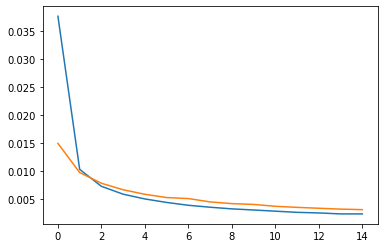

In [264]:
plt.plot(hist['train_loss'])
plt.plot(hist['val_loss'])
plt.show()

In [265]:
test_dataset = CT_Dataset(test_files, test=True, labels=test_labels)
recon_error = get_reconstruction_err(test_dataset, model)

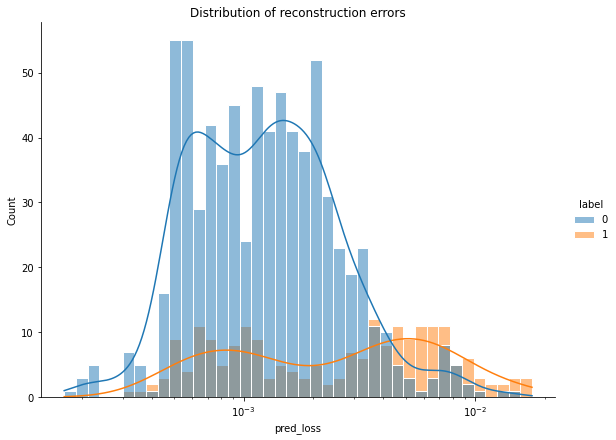

In [266]:
import seaborn as sns
sns.displot(recon_error, x='pred_loss',kde=True, hue='label', bins=40, log_scale=[True, False], height=6, aspect=8/6, edgecolor='white')
plt.title('Distribution of reconstruction errors')
plt.show()

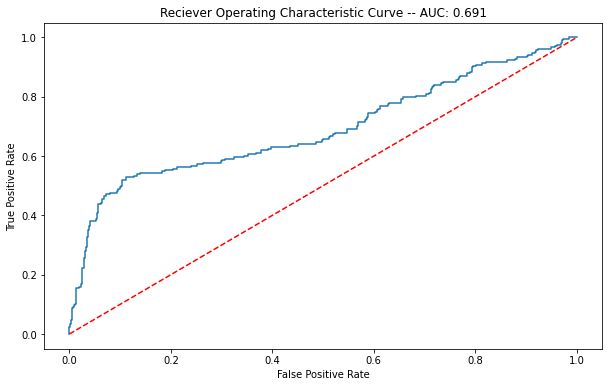

In [267]:
from sklearn.metrics import roc_curve, auc, classification_report

fpr, tpr, thresholds = roc_curve(recon_error.label , recon_error.pred_loss)
roc_auc = auc(fpr, tpr)

plot_auc_roc(tpr, fpr, roc_auc)

In [268]:
best_thres_idx = np.argmax(tpr-fpr)
best_thres = thresholds[best_thres_idx]

recon_error['Pred'] = np.where(recon_error['pred_loss'] <= best_thres, 0, 1)

print(best_thres)

0.002841126872226596


In [269]:
print(classification_report(recon_error['Pred'], recon_error['label']))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       754
           1       0.52      0.57      0.55       192

    accuracy                           0.81       946
   macro avg       0.71      0.72      0.71       946
weighted avg       0.81      0.81      0.81       946



## Custom Transformations

### Randomized SVD

In [272]:
custom_trans_SVD = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((250, 250)),
                                       randSVD_recon()])

train_dataset = CT_Dataset(img_path=train_files, img_transforms=custom_trans_SVD)
val_dataset = CT_Dataset(img_path=val_files, img_transforms=custom_trans_SVD)

In [275]:
model = Autoencoder()
#summary(model, (32, 1, 250, 250)) # shape --> (batch size, num_channels, img_height, img_width)
hist = train_model(model, train_dataset, val_dataset, device, batch_size=30, epochs=10)

Training Start:
Epoch:1 / 10, train loss:0.07813, val loss:0.04188
Epoch:2 / 10, train loss:0.03047, val loss:0.02598
Epoch:3 / 10, train loss:0.02258, val loss:0.02021
Epoch:4 / 10, train loss:0.01638, val loss:0.01451
Epoch:5 / 10, train loss:0.01186, val loss:0.01141
Epoch:6 / 10, train loss:0.00952, val loss:0.00967
Epoch:7 / 10, train loss:0.00822, val loss:0.00864
Epoch:8 / 10, train loss:0.00729, val loss:0.00787
Epoch:9 / 10, train loss:0.00663, val loss:0.00729
Epoch:10 / 10, train loss:0.00609, val loss:0.00686


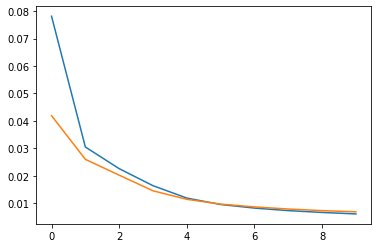

In [276]:
plt.plot(hist['train_loss'])
plt.plot(hist['val_loss'])
plt.show()

In [277]:
test_dataset = CT_Dataset(test_files, test=True, labels=test_labels, img_transforms=custom_trans)
recon_error = get_reconstruction_err(test_dataset, model)

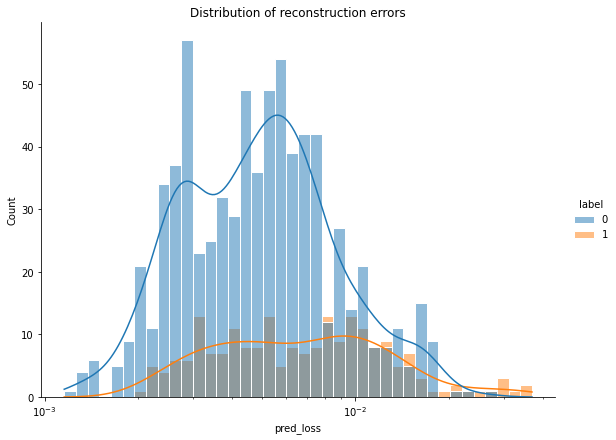

In [278]:
sns.displot(recon_error, x='pred_loss',kde=True, hue='label', bins=40, log_scale=[True, False], height=6, aspect=8/6, edgecolor='white')
plt.title('Distribution of reconstruction errors')
plt.show()

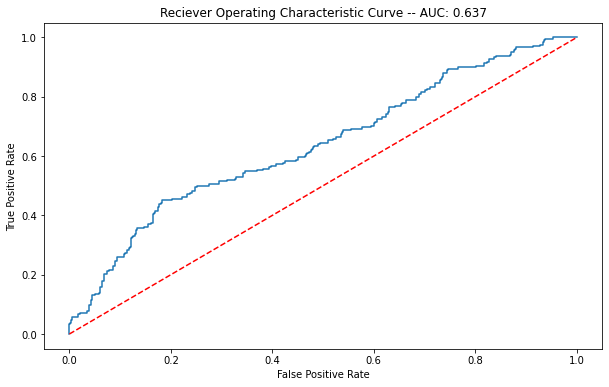

In [279]:
fpr, tpr, thresholds = roc_curve(recon_error.label , recon_error.pred_loss)
roc_auc = auc(fpr, tpr)

plot_auc_roc(tpr, fpr, roc_auc)

In [280]:
best_thres_idx = np.argmax(tpr-fpr)
best_thres = thresholds[best_thres_idx]

recon_error['Pred'] = np.where(recon_error['pred_loss'] <= best_thres, 0, 1)

print(best_thres)

0.00769842928275466


In [281]:
print(classification_report(recon_error['Pred'], recon_error['label']))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       719
           1       0.45      0.41      0.43       227

    accuracy                           0.74       946
   macro avg       0.63      0.62      0.63       946
weighted avg       0.73      0.74      0.73       946



### Non-negative Matrix Factorization

In [294]:
custom_trans_NMF = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((250, 250)),
                                       NMF_reconstruction()])

train_dataset_NMF = CT_Dataset(img_path=train_files, img_transforms=custom_trans_NMF)
val_dataset_NMF = CT_Dataset(img_path=val_files, img_transforms=custom_trans_NMF)

In [295]:
model = Autoencoder()
#summary(model, (32, 1, 250, 250)) # shape --> (batch size, num_channels, img_height, img_width)
hist_NMF = train_model(model, train_dataset_NMF, val_dataset_NMF, device, batch_size=30, epochs=15)

Training Start:
Epoch:1 / 15, train loss:0.10839, val loss:0.05999


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:2 / 15, train loss:0.03775, val loss:0.02944


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:3 / 15, train loss:0.02532, val loss:0.02232


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:4 / 15, train loss:0.01972, val loss:0.01749


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:5 / 15, train loss:0.01484, val loss:0.01331


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:6 / 15, train loss:0.01130, val loss:0.01066


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:7 / 15, train loss:0.00938, val loss:0.00935


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:8 / 15, train loss:0.00828, val loss:0.00846


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:9 / 15, train loss:0.00750, val loss:0.00777


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:10 / 15, train loss:0.00689, val loss:0.00721


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:11 / 15, train loss:0.00636, val loss:0.00674
Epoch:12 / 15, train loss:0.00591, val loss:0.00635


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:13 / 15, train loss:0.00555, val loss:0.00598


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:14 / 15, train loss:0.00518, val loss:0.00563


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


Epoch:15 / 15, train loss:0.00486, val loss:0.00533


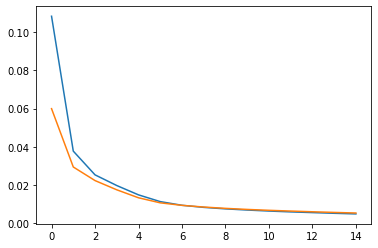

In [296]:
plt.plot(hist_NMF['train_loss'])
plt.plot(hist_NMF['val_loss'])
plt.show()

In [297]:
test_dataset_NMF = CT_Dataset(test_files, test=True, labels=test_labels, img_transforms=custom_trans_NMF)
recon_error = get_reconstruction_err(test_dataset_NMF, model)

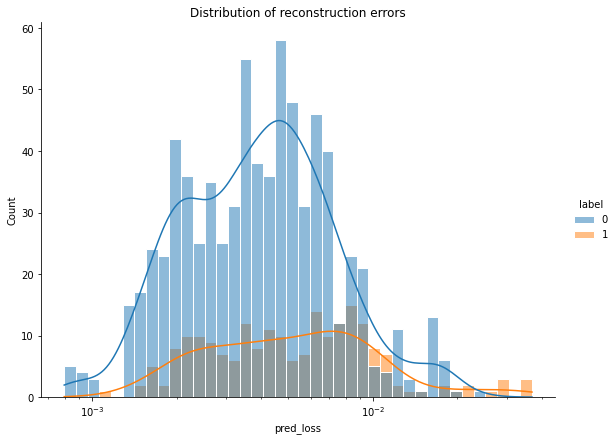

In [299]:
sns.displot(recon_error, x='pred_loss',kde=True, hue='label', bins=40, log_scale=[True, False], height=6, aspect=8/6, edgecolor='white')
plt.title('Distribution of reconstruction errors')
plt.show()

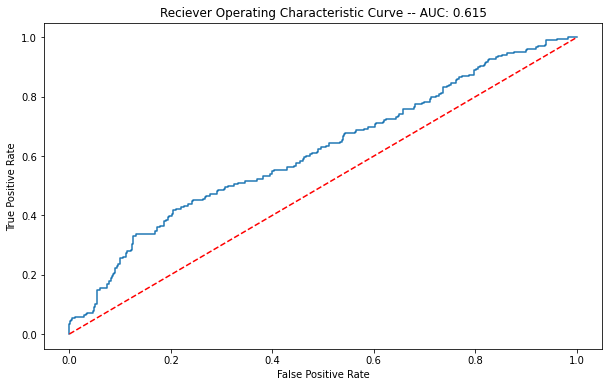

In [300]:
fpr, tpr, thresholds = roc_curve(recon_error.label , recon_error.pred_loss)
roc_auc = auc(fpr, tpr)

plot_auc_roc(tpr, fpr, roc_auc)

In [301]:
best_thres_idx = np.argmax(tpr-fpr)
best_thres = thresholds[best_thres_idx]

recon_error['Pred'] = np.where(recon_error['pred_loss'] <= best_thres, 0, 1)

print(best_thres)

0.006335838697850704


In [302]:
print(classification_report(recon_error['Pred'], recon_error['label']))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       709
           1       0.41      0.36      0.39       237

    accuracy                           0.71       946
   macro avg       0.60      0.60      0.60       946
weighted avg       0.70      0.71      0.70       946

